# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from scipy.stats import ttest_ind
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
import warnings; warnings.simplefilter('ignore')

# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
# загружаем датасеты
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# отмечает тренировочный и тестовый датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [6]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
14972,id_1718,Lisbon,"['European', 'Portuguese']",1720.0,$,119.0,"[['Average food but good enough', 'Great exper...",/Restaurant_Review-g189158-d4766793-Reviews-Re...,d4766793,1,3.5
36544,id_449,Oporto,"['Portuguese', 'Bar', 'Mediterranean', 'Europe...",450.0,$,140.0,"[['Great little lunch spot', 'Great little fin...",/Restaurant_Review-g189180-d8319624-Reviews-Ca...,d8319624,1,4.0
17048,id_367,Barcelona,"['Spanish', 'Grill']",368.0,$$$$,1285.0,"[['Very authentic, nearly all locals. I felt.....",/Restaurant_Review-g187497-d969312-Reviews-Asa...,d969312,1,4.0
31937,id_1083,Warsaw,"['Polish', 'European', 'Arabic']",1084.0,$,NaN,"[[], []]",/Restaurant_Review-g274856-d13323744-Reviews-S...,d13323744,1,5.0
35128,id_3458,Madrid,['Italian'],3460.0,$,5.0,"[['A small bundle of Italian joy!'], ['07/06/2...",/Restaurant_Review-g187514-d10210890-Reviews-I...,d10210890,1,4.5


In [7]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

# Функции

In [8]:
#Положительные слова в отзывах ресторанов
def good_words(scroll):
    
    i = 0
    for word in scroll:
        for mood in key_words:
            if mood == word.lower():
                i += 1
    return i

#Вывод основных статистических данных категориальных признаков
def categorical_data_value(col):

    display(pd.DataFrame(data[col].value_counts()))
    display(data[col].describe())

# Построение гистограммы и вывод основных статистических данных цифровых признаков
def numerical_data_value(col):
    
    display(data[col].hist(bins=100))
    display(data[col].describe())

# Построение гистограммы цифровых признаков с выбросами, а также вывод границ выбросов
def numerical_hist(col, end):

    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    l_side = perc25 - 1.5*IQR
    r_side = perc75 + 1.5*IQR
    print('25 percentile: {}'.format(perc25),
          '\n75 percentile: {}'.format(perc75),
          '\nData Outlier Boundaries:',
          '\nleft: {}'.format(l_side),
          '\nright: {}'.format(r_side))
    data[col].loc[data[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]\
        .hist(bins=100, range=(0, end), label='values')
    data[col].loc[data[col] >= r_side].hist(alpha=0.5, bins=100, range=(0, end),
                                        label='Data Outlier')
    plt.legend()
    
# Нормализация признака
def normalise_col(column):

    scaler = MinMaxScaler()
    get_column = pd.DataFrame(data[column])
    get_column_norm = scaler.fit_transform(get_column)
    return get_column_norm


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   

In [9]:
pd.DataFrame(data.isna().sum(), columns=['NaN'])

,NaN
Restaurant_id,0
City,0
Cuisine Style,11590
Ranking,0
Price Range,17361
Number of Reviews,3200
Reviews,2
URL_TA,0
ID_TA,0
sample,0


In [10]:
#сделаем колонки красивее и удобнее в использовании
data.columns = ['_'.join(col.split()).lower() for col in data.columns]

In [11]:
data.columns

Index(['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'url_ta', 'id_ta', 'sample', 'rating'],
      dtype='object')

# city

In [12]:
categorical_data_value('city')

,city
London,7193
Paris,6108
Madrid,3813
Barcelona,3395
Berlin,2705
Milan,2694
Rome,2589
Prague,1816
Lisbon,1647
Vienna,1443


count      50000
unique        31
top       London
freq        7193
Name: city, dtype: object

# cuisine_style

In [13]:
data['cuisine_style'].fillna('Traditional', inplace=True)

# restaurant_id

In [14]:
categorical_data_value('restaurant_id')

,restaurant_id
id_871,19
id_633,19
id_436,19
id_227,19
id_585,18
...,...
id_10748,1
id_13927,1
id_12475,1
id_15500,1


count      50000
unique     13094
top       id_871
freq          19
Name: restaurant_id, dtype: object

# reviews

In [15]:
data['reviews_temp'] = data.reviews.dropna().apply(
    lambda x: np.nan if x == '[[], []]' else x.split(', [')[0])
data['review_temp_count'] = data['reviews_temp'].str.replace(
    '"', "'").str.split(", '").str.len()

data['dates_temp'] = data.reviews.dropna().apply(
    lambda x: np.nan if x == '[[], []]' else x.split(', [')[1])
data.loc[data.dates_temp == "59], ju...']", 'dates_temp'] = "'05/10/2015', '07/05/2014']]"

data['dates_temp_count'] = data['dates_temp'].str.split(", '").str.len()

data['review_1_temp'] = data.reviews_temp.dropna().str.replace('"', "'").apply(
    lambda x: x[3:-3].split(", '")[0])
data['review_1'] = data.review_1_temp.dropna().apply(lambda x: x[:-1])

data['date_1_temp'] = data.dates_temp.dropna().apply(
    lambda x: x[1:-2].split(", '")[0])
data['date_1_s'] = data.date_1_temp.dropna().apply(lambda x: x[:-1])
data['date_1'] = data.date_1_s.dropna().apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
data['review_2'] = data[data.review_temp_count > 1].reviews_temp.dropna(
).str.replace('"', "'").apply(lambda x: x[3:-3].split(", '")[1])
data['date_2_s'] = data[data.dates_temp_count > 1].dates_temp.dropna().apply(
    lambda x: x[1:-3].split(", '")[1])
data['date_2'] = data.date_2_s.dropna().apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
data.drop(['reviews_temp', 'review_temp_count', 'dates_temp', 'dates_temp_count',
         'review_1_temp', 'date_1_temp', 'date_1_s',
         'date_2_s'], axis=1, inplace=True)

#  number_of_reviews

In [16]:
data['dates_temp'] = data.reviews.dropna().apply(
    lambda x: np.nan if x == '[[], []]' else x.split(', [')[1])
data['dates_temp_count'] = data['dates_temp'].str.split(", '").str.len()

mask_rev = (data.number_of_reviews.isna()) & (data.dates_temp_count == 1)
data.loc[mask_rev, 'number_of_reviews'] = data.loc[mask_rev,
                                            'number_of_reviews'].fillna(1)
data.number_of_reviews.fillna(0, inplace=True)

data.drop(['dates_temp', 'dates_temp_count'], axis=1, inplace=True)

count    50000.000000
mean       116.528560
std        286.163568
min          0.000000
25%          7.000000
50%         28.000000
75%        105.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

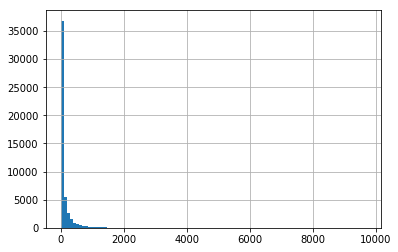

In [17]:
numerical_data_value('number_of_reviews')

25 percentile: 7.0 
75 percentile: 105.0 
Data Outlier Boundaries: 
left: -140.0 
right: 252.0


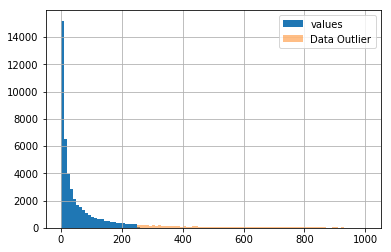

In [18]:
numerical_hist('number_of_reviews', 1000)

In [19]:
len(data[(data.number_of_reviews > 1000) & (data['sample'] == 1)])

673

#  review_mood

count    50000.000000
mean         0.959120
std          0.975904
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          7.000000
Name: review_mood, dtype: float64

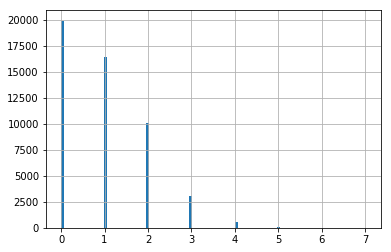

In [20]:
key_words = ['good','great','nice','best','excellent','but','delicious', 'friendly', 'lovely', 'amazing', 'tasty', 'little']
data['words'] = data.reviews.str.findall(r"(\w+)")
data['review_mood'] = data.words.dropna().apply(good_words)
data.review_mood.fillna(0, inplace=True)
numerical_data_value('review_mood')

# ranking

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: ranking, dtype: float64

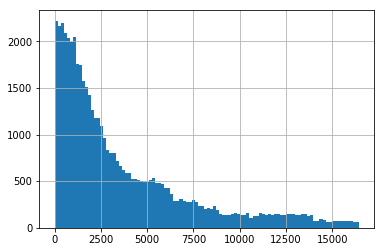

In [21]:
numerical_data_value('ranking')

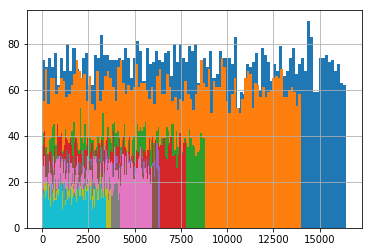

In [22]:
for x in (data['city'].value_counts())[0:10].index:
    data['ranking'][data['city'] == x].hist(bins=100)
plt.show()

 # rating

count    50000.000000
mean         3.194430
std          1.705453
min          0.000000
25%          3.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

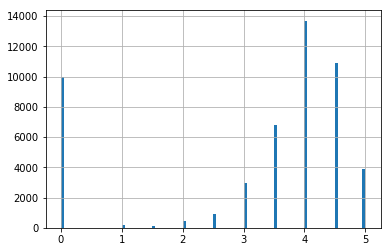

In [23]:
numerical_data_value('rating')

# price_range

In [24]:
categorical_data_value('price_range')

,price_range
$$ - $$$,23041
$,7816
$$$$,1782


count        32639
unique           3
top       $$ - $$$
freq         23041
Name: price_range, dtype: object

In [25]:
data.price_range.fillna('$$ - $$$', inplace=True)

In [26]:
data['price_range'].replace({'$': 5,'$$ - $$$': 50,'$$$$': 500}, inplace = True)

In [27]:
categorical_data_value('price_range')

,price_range
50,40402
5,7816
500,1782


count    50000.000000
mean        59.003600
std         86.329209
min          5.000000
25%         50.000000
50%         50.000000
75%         50.000000
max        500.000000
Name: price_range, dtype: float64

# median_city_price

count    50000.000000
mean        59.003600
std          6.049117
min         48.862816
25%         55.822711
50%         59.075531
75%         60.958904
max         87.220339
Name: median_city_price, dtype: float64

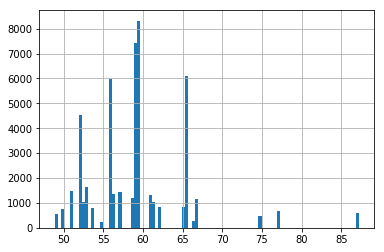

In [28]:
median_city_price = data.groupby('city').price_range.mean().to_dict()
data['median_city_price'] = data.city.map(median_city_price)
numerical_data_value('median_city_price')

### 2. Нормализация признаков


In [29]:
rank_city_min = data.groupby(['city'])['ranking'].min().to_dict()
rank_city_max = data.groupby(['city'])['ranking'].max().to_dict()
data['rank_city_min'] = data.city.map(rank_city_min)
data['rank_city_max'] = data.city.map(rank_city_max)
data['rank_norm'] = data.apply(lambda x: (
    x['ranking'] - x['rank_city_min'])/(x['rank_city_max'] - x['rank_city_min']), axis=1)

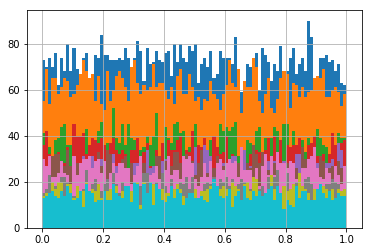

In [30]:
for x in (data['city'].value_counts())[0:10].index:
    data['rank_norm'][data['city'] == x].hist(bins=100)
plt.show()

In [31]:
data['review_mood_normalise'] = normalise_col('review_mood')
data['price_normalise'] = normalise_col('price_range')
data['num_rev_normalise'] = normalise_col('number_of_reviews')

# Добавление данных

## Популяция

In [32]:
population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

data['population'] = data.city.map(population)

## Столица

In [33]:
capital = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague',
          'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
          'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens',
          'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava',
          'Luxembourg', 'Ljubljana']
data['is_capital'] = data.city.apply(lambda x: 1 if x in capital else 0)

## Покупательская способность

In [34]:
purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

data['purchasing_power'] = data.city.map(purchasing_power_index)

## ранг ресторана

In [35]:
data['ranking_of_reviews'] = data.ranking * data.number_of_reviews

## соотношение ресторана и числа людей

In [36]:
data['reviews_per_population'] = data.number_of_reviews / data.population

## максимальный ранг

In [37]:
ranking_max_per_city = data.groupby('city')['ranking'].max()
data['rating_max_per_city'] = data.city.map(ranking_max_per_city)

# Анализ данных

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
restaurant_id             50000 non-null object
city                      50000 non-null object
cuisine_style             50000 non-null object
ranking                   50000 non-null float64
price_range               50000 non-null int64
number_of_reviews         50000 non-null float64
reviews                   49998 non-null object
url_ta                    50000 non-null object
id_ta                     50000 non-null object
sample                    50000 non-null int64
rating                    50000 non-null float64
review_1                  41886 non-null object
date_1                    41886 non-null datetime64[ns]
review_2                  36205 non-null object
date_2                    36206 non-null datetime64[ns]
words                     49998 non-null object
review_mood               50000 non-null float64
median_city_price         50000 non-null float64
rank_cit

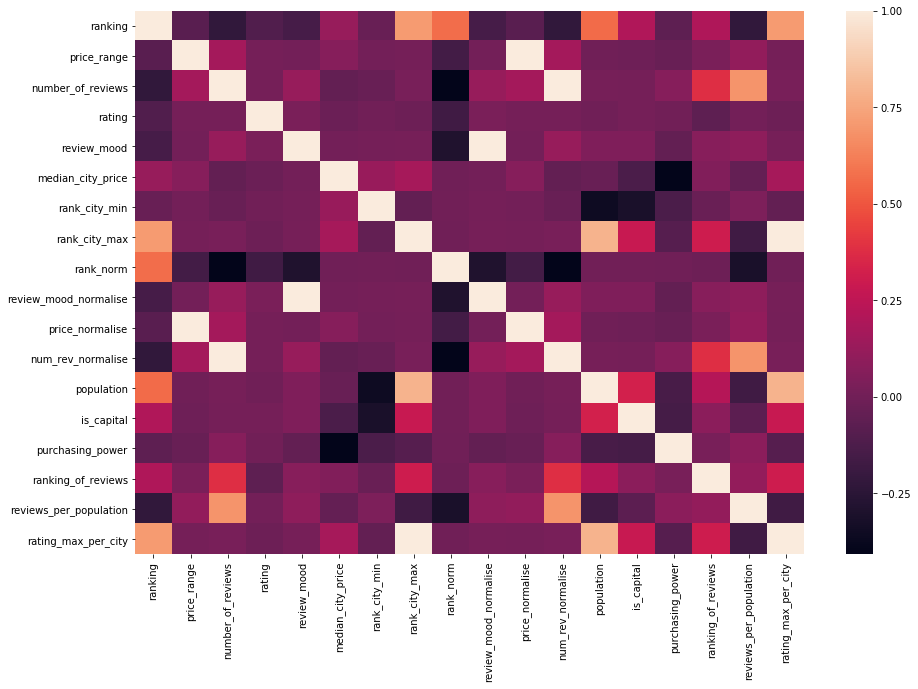

In [39]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [40]:
data.drop(['cuisine_style', 'review_mood', 'price_range','ranking',
         'number_of_reviews', 'id_ta', 'url_ta', 'restaurant_id'], axis=1, inplace=True)

# Dummy

In [41]:
data.columns

Index(['city', 'reviews', 'sample', 'rating', 'review_1', 'date_1', 'review_2',
       'date_2', 'words', 'median_city_price', 'rank_city_min',
       'rank_city_max', 'rank_norm', 'review_mood_normalise',
       'price_normalise', 'num_rev_normalise', 'population', 'is_capital',
       'purchasing_power', 'ranking_of_reviews', 'reviews_per_population',
       'rating_max_per_city'],
      dtype='object')

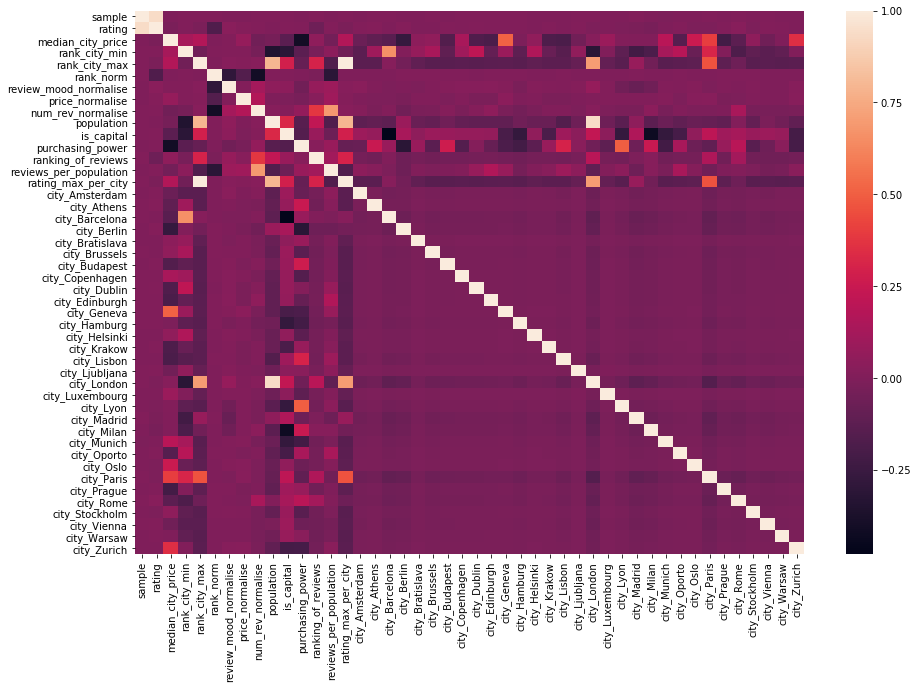

In [42]:
data = pd.get_dummies(data, columns=['city', ], dummy_na=True)
data.drop('city_nan', axis=1, inplace=True)

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(),)

In [43]:
data.head(2)

,reviews,sample,rating,review_1,date_1,review_2,date_2,words,median_city_price,rank_city_min,rank_city_max,rank_norm,review_mood_normalise,price_normalise,num_rev_normalise,population,is_capital,purchasing_power,ranking_of_reviews,reviews_per_population,rating_max_per_city,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,...,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,"[[], []]",0,0.0,NaN,NaT,NaN,NaT,[],65.478880,3.0,13986.0,0.92684,0.000000,0.090909,0.000414,2148271,1,22,51852.0,0.000002,13986.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,Very good reviews!,2017-12-05,Fine dining in Hakaniem,2017-10-29,"[Very, good, reviews, Fine, dining, in, Hakani...",62.221053,4.0,1141.0,0.08971,0.142857,0.090909,0.010041,656229,1,9,10282.0,0.000148,1141.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
data.drop(['reviews', 'reviews', 'review_1', 'date_1',
         'review_2', 'date_2', 'words'], axis=1, inplace=True)
data.head(2)

,sample,rating,median_city_price,rank_city_min,rank_city_max,rank_norm,review_mood_normalise,price_normalise,num_rev_normalise,population,is_capital,purchasing_power,ranking_of_reviews,reviews_per_population,rating_max_per_city,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,0,0.0,65.478880,3.0,13986.0,0.92684,0.000000,0.090909,0.000414,2148271,1,22,51852.0,0.000002,13986.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0.0,62.221053,4.0,1141.0,0.08971,0.142857,0.090909,0.010041,656229,1,9,10282.0,0.000148,1141.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Запускаем и проверяем что получилось

In [45]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.rating.values            # наш таргет
X = train_data.drop(['rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [46]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [47]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 45), (40000, 45), (40000, 44), (32000, 44), (8000, 44))

# Model 
Сам ML

In [48]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [49]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [50]:
y_pred = np.round(y_pred * 2) / 2

In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.179125


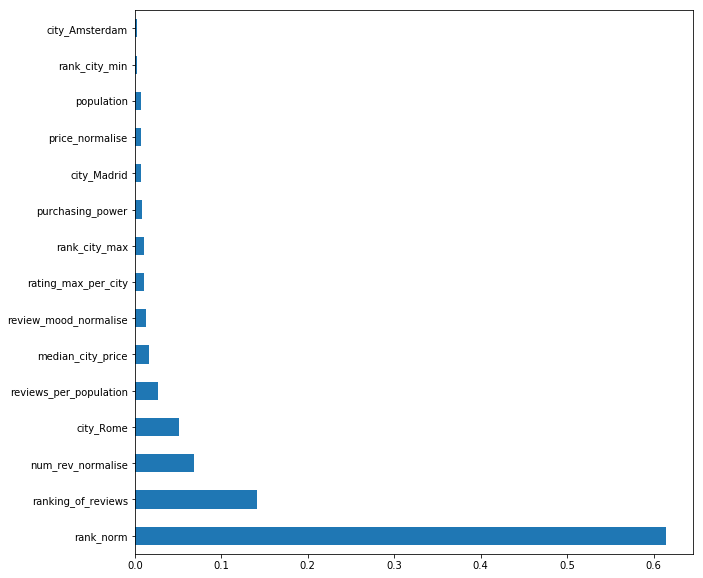

In [52]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [53]:
test_data.sample(10)

,rating,median_city_price,rank_city_min,rank_city_max,rank_norm,review_mood_normalise,price_normalise,num_rev_normalise,population,is_capital,purchasing_power,ranking_of_reviews,reviews_per_population,rating_max_per_city,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
1321,0.0,76.934307,2.0,1601.0,0.471545,0.142857,0.000000,0.001346,415215,0,2,9828.0,0.000031,1601.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3486,0.0,51.022727,4.0,1960.0,0.648262,0.142857,0.090909,0.000311,554554,1,27,3816.0,0.000005,1960.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6486,0.0,61.151985,1.0,2464.0,0.608201,0.285714,0.090909,0.000311,975904,1,13,4497.0,0.000003,2464.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6716,0.0,52.424094,1.0,2440.0,0.695777,0.142857,0.090909,0.002795,1752286,1,51,45846.0,0.000015,2440.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5031,0.0,59.136971,1.0,6275.0,0.893529,0.000000,0.090909,0.000621,1399860,0,40,33642.0,0.000004,6275.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
140,0.0,59.075531,1.0,8809.0,0.448797,0.000000,0.090909,0.001242,3223334,1,23,47448.0,0.000004,8809.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9436,0.0,65.478880,3.0,13986.0,0.272903,0.000000,0.000000,0.002381,2148271,1,22,87837.0,0.000011,13986.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9070,0.0,55.822711,1.0,5948.0,0.588868,0.000000,0.000000,0.002899,2860009,1,37,98084.0,0.000010,5948.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5586,0.0,58.902703,1.0,2154.0,0.908500,0.000000,0.090909,0.000000,1793579,1,29,0.0,0.000000,2154.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4075,0.0,59.075531,1.0,8809.0,0.424955,0.000000,0.090909,0.002277,3223334,1,23,82368.0,0.000007,8809.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [54]:
test_data = test_data.drop(['rating'], axis=1)

In [55]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [56]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [57]:
predict_submission

array([2.955, 4.13 , 4.53 , ..., 3.06 , 4.47 , 4.265])

In [58]:
sample_submission['rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating,rating
0,id_0,2.0,2.955
1,id_1,2.5,4.130
2,id_2,4.0,4.530
3,id_3,1.0,4.445
4,id_4,4.0,4.425
5,id_5,4.5,4.655
6,id_6,4.5,1.590
7,id_7,2.0,3.505
8,id_8,2.0,4.160
9,id_9,3.5,4.700
